<a href="https://colab.research.google.com/github/HarryPotter12/PractiseML/blob/master/AML_Ass2_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 3. Random Forests: (5 + 2.5 + 2.5 = 10 marks)
(a) Write your own random forest classifier (this should be relatively easy, given you have written your own decision tree code) to apply to the Spam dataset [[data](http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/spam.data), [information](http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/spam.info.txt)]. \
Use 30% of the provided data as test data and the remaining for training. \
Compare your results in terms of accuracy and time taken with Scikitlearn's built-in random forest classifier. (Note that you can't use in-built decision tree functions to implement your code. You can modify your decision tree code of the Assignment 1, or code a new one, to implement a random forest. You can however use the inbuilt train test split of sklearn to divide the data into train and test.)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!rm -f spam*
!rm -f *.py

In [ ]:
!wget http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/spam.data
!cp '/content/gdrive/My Drive/My Python Scripts/'*.py /content/

--2020-11-25 17:46:37--  http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/spam.data
Resolving statweb.stanford.edu (statweb.stanford.edu)... 171.67.24.34
Connecting to statweb.stanford.edu (statweb.stanford.edu)|171.67.24.34|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data [following]
--2020-11-25 17:46:37--  https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 698341 (682K)
Saving to: ‘spam.data’

spam.data           100%[===================>] 681.97K   992KB/s    in 0.7s    

2020-11-25 17:46:38 (992 KB/s) - ‘spam.data’ saved [698341/698341]



In [ ]:
import numpy as np
import pandas as pd
import time

import random
import matplotlib.pyplot as plt

from helper_functions import my_train_test_split, calculate_accuracy
from decision_tree_functions import decision_tree_algorithm, decision_tree_predictions

In [ ]:
df = pd.read_csv("/content/spam.data",sep='\s*',header=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py:2547: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py:2550: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


### Personal Implementation

In [ ]:
df["label"] = df[df.columns[-1]]
df = df.drop(df.columns[-2], axis=1)
df.columns = df.columns.astype(str)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [ ]:
random.seed(42)
train_df, test_df = my_train_test_split(df, test_size=0.3)

train_df

In [ ]:
def bootstrapping(train_df, n_bootstrap):
  bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
  df_bootstrapped = train_df.iloc[bootstrap_indices]
  oob_indices = [i for i in range(len(train_df)) if i not in bootstrap_indices]
  df_oob = train_df.iloc[oob_indices]
  
  return df_bootstrapped, df_oob

def calculate_oob_error(tree, df_oob):
  mis_label = 0
  pred = decision_tree_predictions(df_oob, tree)
  for i in range(len(df_oob)):
    if pred.iloc[i] != df_oob.iloc[i,-1]:
      mis_label += 1
  return mis_label / len(df_oob)

def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
  forest = []
  oob_ls = []
  for i in range(n_trees):
    df_bootstrapped, df_oob = bootstrapping(train_df, n_bootstrap)
    tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
    if str(type(tree)) != "<class 'numpy.float64'>":
      forest.append(tree)
      oob_error = calculate_oob_error(tree, df_oob)
      oob_ls.append(oob_error)
  return forest, oob_ls

def random_forest_predictions(test_df, forest):
  df_predictions = {}
  for i in range(len(forest)):
    column_name = "tree_{}".format(i)
    predictions = decision_tree_predictions(test_df, tree=forest[i])
    df_predictions[column_name] = predictions

  df_predictions = pd.DataFrame(df_predictions)
  random_forest_predictions = df_predictions.mode(axis=1)[0]
  
  return random_forest_predictions

In [ ]:
start = time.time()

forest, forest_oob_ls = random_forest_algorithm(train_df, n_trees=100, n_bootstrap=1200, n_features=57, dt_max_depth=45)
predictions = random_forest_predictions(test_df, forest)

end = time.time()
accuracy = calculate_accuracy(predictions, test_df.label)

print("Accuracy in My Implementation : {}".format(accuracy))
print("OOB Error in My Implementation : {:.2f}".format(np.mean(forest_oob_ls)))
print("Total runtime of the program is {} seconds".format(end - start))

Accuracy in My Implementation : 0.9369565217391305
OOB Error in My Implementation : 0.11
Total runtime of the program is 904.8131024837494 seconds


### ScikitLearn Implementation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
start = time.time()

clf=RandomForestClassifier(criterion="entropy", max_features=None, oob_score=True, max_samples=1200, max_depth=45, random_state=42)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

end = time.time()

print("Accuracy in SKLearn :", metrics.accuracy_score(y_test, y_pred))
print("OOB Error :", 1-clf.oob_score_)
print("Test Error :",1-metrics.accuracy_score(y_test, y_pred))
print("Total runtime of the program is {} seconds".format(end - start))

Accuracy in SKLearn : 0.9471397538015931
OOB Error : 0.06242236024844716
Test Error : 0.0528602461984069
Total runtime of the program is 1.8944835662841797 seconds


(b) Explore the sensitivity of Random Forests to the parameter m (the number of features
used for best split).

In [ ]:
oob_errors = []
test_errors = []
for i in range(1,11):
  start = time.time()

  forest, forest_oob_ls = random_forest_algorithm(train_df, n_trees=100, n_bootstrap=1200, n_features=i, dt_max_depth=45)
  predictions = random_forest_predictions(test_df, forest)

  end = time.time()
  accuracy = calculate_accuracy(predictions, test_df.label)
  oob_errors.append(np.mean(forest_oob_ls))
  test_errors.append(1-accuracy)

  print("No. of Features : {}".format(i))
  print("Accuracy in My Implementation : {}".format(accuracy))
  print("OOB Error in My Implementation : {:.2f}".format(oob_errors[i-1]))
  print("Total runtime of the program is {} seconds".format(end - start))
  print()

No. of Features : 1
Accuracy in My Implementation : 0.9014492753623189
OOB Error in My Implementation : 0.19
Total runtime of the program is 48.72276830673218 seconds

No. of Features : 2
Accuracy in My Implementation : 0.9326086956521739
OOB Error in My Implementation : 0.14
Total runtime of the program is 74.74606728553772 seconds

No. of Features : 3
Accuracy in My Implementation : 0.9376811594202898
OOB Error in My Implementation : 0.14
Total runtime of the program is 92.03992676734924 seconds

No. of Features : 4
Accuracy in My Implementation : 0.9347826086956522
OOB Error in My Implementation : 0.13
Total runtime of the program is 106.18241715431213 seconds

No. of Features : 5
Accuracy in My Implementation : 0.9398550724637681
OOB Error in My Implementation : 0.13
Total runtime of the program is 123.28477144241333 seconds

No. of Features : 6
Accuracy in My Implementation : 0.9369565217391305
OOB Error in My Implementation : 0.12
Total runtime of the program is 137.9098489284515

Varying the number of features used for best split from 1 to 10, we can see that the accuracy as well as the OOB Error starts getting saturated near 7 which is $\approx\sqrt{Total\ number\ of\ features}$ i.e. $\sqrt{57}$

(c) Plot the OOB (out-of-bag) error (you have to find what this is, and read about it!) and
the test error against a suitably chosen range of values for m. (Use your implementation
of random forest to perform this analysis.)

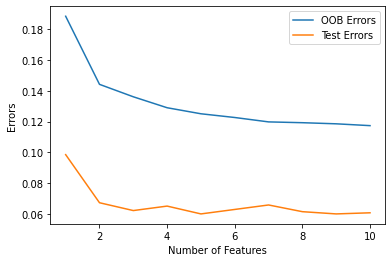

In [ ]:
plt.plot(range(1,11), oob_errors, label="OOB Errors")
plt.plot(range(1,11), test_errors, label="Test Errors")
plt.ylabel('Errors')
plt.xlabel('Number of Features')
plt.legend(loc="upper right")
plt.show()